<a href="https://colab.research.google.com/github/Karthik1104/ML-Repository/blob/main/Titanic_ML_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Machine Learning Task
This notebook performs EDA, preprocessing, feature engineering, model training, and hyperparameter tuning on the Titanic dataset. Chained assignment inplace warnings are fixed for future pandas compatibility.

In [11]:

# 1Setup & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

%matplotlib inline


In [12]:

# Load Titanic Dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving Titanic-Dataset (2).csv to Titanic-Dataset (2) (1).csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:

#  Basic Info & Missing Values
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
df.describe(include='all').T


Dataset shape: (891, 12)

Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Dooley, Mr. Patrick",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


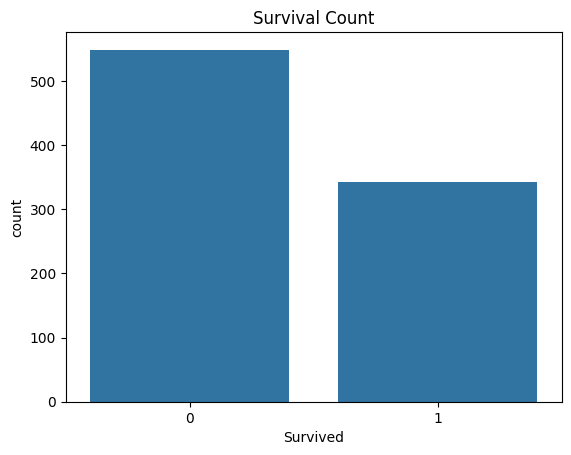

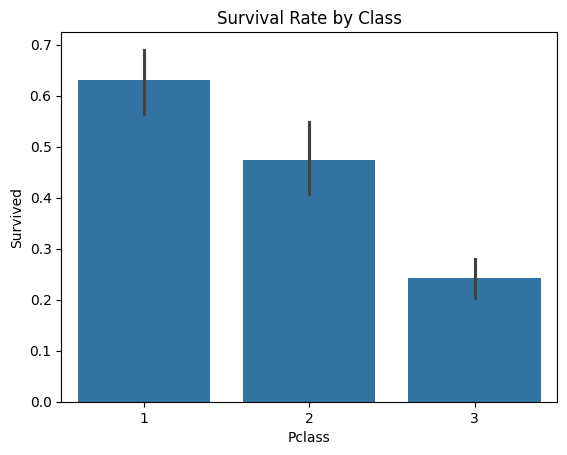

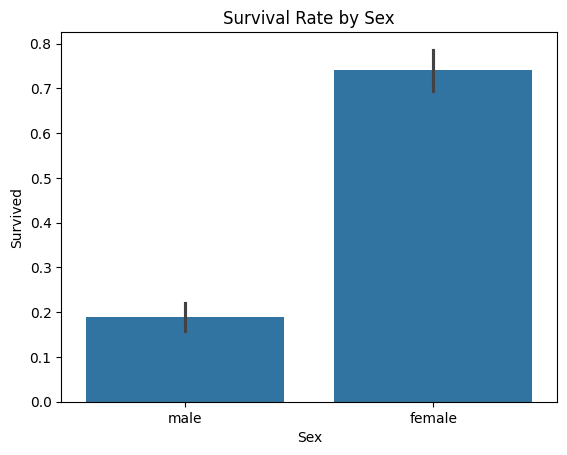

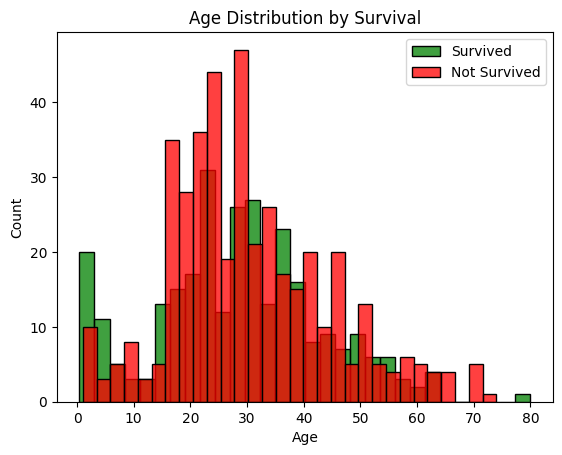

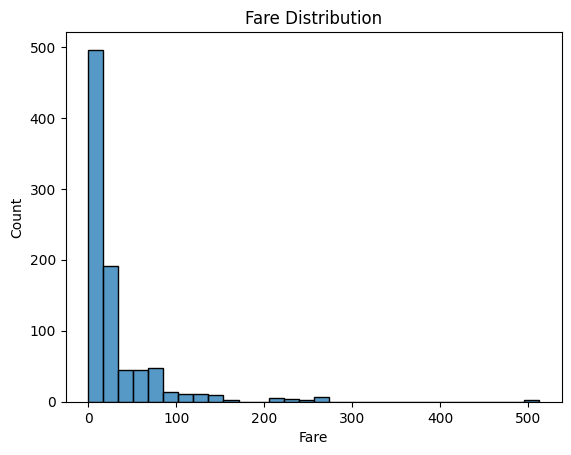

In [14]:

# Exploratory Data Analysis (EDA)
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

sns.barplot(x='Pclass', y='Survived', data=df)
plt.title("Survival Rate by Class")
plt.show()

sns.barplot(x='Sex', y='Survived', data=df)
plt.title("Survival Rate by Sex")
plt.show()

sns.histplot(df[df['Survived']==1]['Age'].dropna(), bins=30, color='green', label='Survived')
sns.histplot(df[df['Survived']==0]['Age'].dropna(), bins=30, color='red', label='Not Survived')
plt.legend()
plt.title("Age Distribution by Survival")
plt.show()

sns.histplot(df['Fare'].dropna(), bins=30)
plt.title("Fare Distribution")
plt.show()


In [15]:

# Preprocessing & Feature Engineering
df2 = df.copy()
df2['Age'] = df2['Age'].fillna(df2['Age'].median())
df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])

df2.drop(columns=['Cabin', 'Ticket'], inplace=True, errors='ignore')

df2['Title'] = df2['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
rare_titles = df2['Title'].value_counts()[df2['Title'].value_counts() < 10].index
df2['Title'] = df2['Title'].replace(rare_titles, 'Other')

df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2['IsAlone'] = (df2['FamilySize'] == 1).astype(int)

passenger_ids = df2['PassengerId']
df2.drop(columns=['Name', 'PassengerId'], inplace=True)

df2 = pd.get_dummies(df2, drop_first=True)

X = df2.drop('Survived', axis=1)
y = df2['Survived']

scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)


In [16]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [17]:


# Train & Compare Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    }
    print(f"\n{name} Report:\n", classification_report(y_test, preds))

pd.DataFrame(results).T



LogisticRegression Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       110
           1       0.84      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179


RandomForest Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


GradientBoosting Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80      

,Accuracy,Precision,Recall,F1
LogisticRegression,0.854749,0.841270,0.768116,0.803030
RandomForest,0.821229,0.776119,0.753623,0.764706
GradientBoosting,0.815642,0.810345,0.681159,0.740157


In [18]:

#  Hyperparameter Tuning - RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)

best_rf = gs.best_estimator_
preds_rf = best_rf.predict(X_test)
print("\nTuned RandomForest Report:\n", classification_report(y_test, preds_rf))


Best parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}

Tuned RandomForest Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



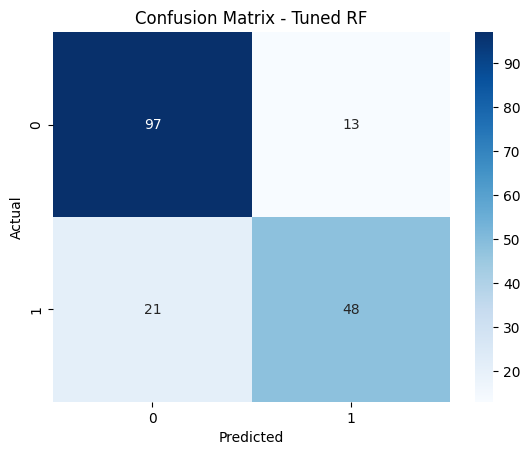

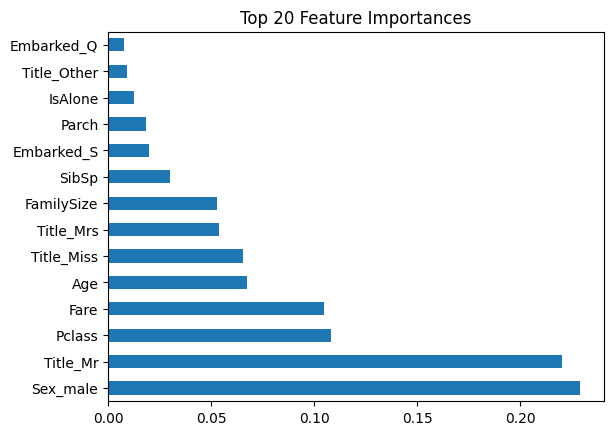

In [19]:

#  Confusion Matrix & Feature Importances
cm = confusion_matrix(y_test, preds_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()


In [20]:

#  Save Predictions to CSV
output = pd.DataFrame({
    'PassengerId': passenger_ids.iloc[X_test.index],
    'Survived_Pred': preds_rf
})

output.to_csv("titanic_predictions.csv", index=False)
print("Predictions saved as titanic_predictions.csv")


Predictions saved as titanic_predictions.csv
